In [ ]:
!pip install -q lucifer-ml

<textarea disabled name="comments" id="comments" style="width:97%;font:36px/44px cursive;border:10px double yellowgreen;text-align:center">
Imports
</textarea><br>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import missingno as msno
from luciferml.preprocessing import Preprocess as prep
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report


import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("../input/water-potability/water_potability.csv")
df.head()

<textarea disabled name="comments" id="comments" style="width:97%;font:36px/44px cursive;border:10px double yellowgreen;text-align:center">
EDA
</textarea><br>

## Missing Values

In [ ]:
msno.matrix(df)

Checking if there is any pattern in missing values

In [ ]:
msno.heatmap(df)

Calculating total missing values

In [ ]:
df.isna().sum()

## Correlation

In [ ]:
df.corr()

<b> NO Multicollinearity </b>
><b>What Is Multicollinearity?</b>
<br>
Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. Multicollinearity can lead to skewed or misleading results when a researcher or analyst attempts to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model.

In [ ]:
sns.pairplot(df, kind="reg")
plt.show()

**Infrence**: None of them following any relation

In [ ]:
fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(10, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.hist(column = df.columns[i], bins = 100, ax=axis)
        i = i+1

**Infrence**: Solids is skewed

In [ ]:
fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(15, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.histplot(data=df, x=df.columns[i], bins = 100, ax=axis, hue='Potability',element="step")
        i = i+1

# Filling Missing Values

In [ ]:
sns.histplot(df[['ph']], kde=True)
plt.show()

In [ ]:
sns.boxplot(x=df[['ph']].values)
plt.show()

In [ ]:
sns.boxplot(x=df[['ph']].fillna(df[['ph']].median()).values)
plt.show()

In [ ]:
try:
    statistics.mode(df[['ph']].values.squeeze())
except statistics.StatisticsError as e:
    print(e)

As in the above graphs, the count of outliers are there so we are using **median** and not **mean**. And we can not use **mode** since all values are unique.
<br>
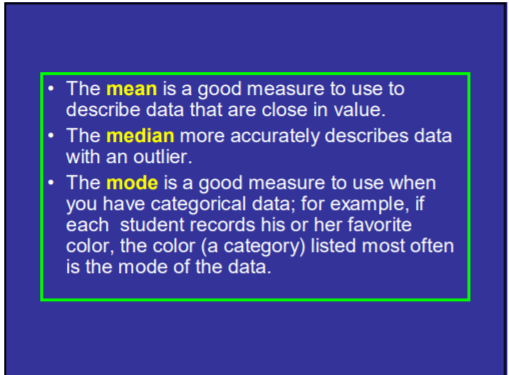

In [ ]:
df[['ph']] = df[['ph']].fillna(df[['ph']].median())

In [ ]:
sns.histplot(df[['ph']], kde=True)
plt.show()

------------------------------------------------------------

In [ ]:
sns.boxplot(df[['Sulfate']].values)
plt.show()

In [ ]:
sns.boxplot(x=df[['Sulfate']].fillna(df[['Sulfate']].median()).values)
plt.show()

In [ ]:
df[['Sulfate']]=df[['Sulfate']].fillna(df[['Sulfate']].median())

In [ ]:
sns.histplot(df[['Sulfate']], kde=True)
plt.show()

--------------

In [ ]:
sns.boxplot(x=df[['Trihalomethanes']].values)
plt.show()

In [ ]:
df[['Trihalomethanes']] = df[['Trihalomethanes']].fillna(df[['Trihalomethanes']].median())

In [ ]:
sns.boxplot(x=df[['Trihalomethanes']].values)
plt.show()

In [ ]:
sns.histplot(df[['Trihalomethanes']], kde=True)
plt.show()

In [ ]:
df.isna().sum()

---

In [ ]:
def correct_skewness(data):
    
    '''
        Function to correct the data skewness;
            data: takes data as input.
                (Funtion takes data for the operation and uses except column to exclude that particular colum
                from the datset.)
    '''
    data_set = prep.skewcorrect(data, except_columns=['Potability'])
    return data_set

data_set = correct_skewness(df)

----

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[:,:-1])
y = df.iloc[:,-1]

---

In [ ]:
# After balancing the dataset was performing bit better

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(1, 2, 1)
plt.title("BEFORE")
df['Potability'].value_counts().plot(kind='pie',autopct='%1.2f%%',colors=['lightcoral','lime'], startangle=90,textprops={'fontsize': 14})
plt.subplot(1, 2, 2)
plt.title("AFTER")
y.value_counts().plot(kind='pie',autopct='%1.2f%%',colors=['lightcoral','lime'], startangle=90,textprops={'fontsize': 14})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

----

<textarea disabled name="comments" id="comments" style="width:97%;font:36px/44px cursive;border:10px double yellowgreen;text-align:center">
MODELS
</textarea><br>

In [ ]:
def make_model(name, model, parameters=None, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    model_og = model
    model_og.fit(X_train, y_train)
    print(name)
    print("-"*10)
    print("Scores without GRIDSEARCH")
    y_pred = model_og.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
    plt.show()
    print("-"*10)
    
    if parameters:
        model_with = GridSearchCV(model, parameters)
        model_with.fit(X_train, y_train)
        print("Best Params : ", model_with.best_params_)
        print("-"*10)
        print("Scores with GRIDSEARCH")
        y_pred = model_with.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
        plt.show()
        print("-"*10)
        return model_og, model_with.best_estimator_
    else: 
        return model_og

In [ ]:
LR, LR_grid = make_model("Logistic Regression", LogisticRegression(), {'penalty':['l1', 'l2', 'elasticnet', 'none'], 'C':[1, 10]})

In [ ]:
svc, svc_grid = make_model('SVC', svm.SVC(), {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 10], 'degree':[3, 5, 7]})

In [ ]:
tree, tree_grid = make_model("Desicion Tree", DecisionTreeClassifier(), {'criterion': ['gini', 'entropy'], 'splitter': ['best','random']})

In [ ]:
knn, knn_grid = make_model('K-Nearest', KNeighborsClassifier(), {'n_neighbors':[3, 5, 9, 7], 'weights' : ['uniform', 'distance']})

In [ ]:
RF, RF_grid = make_model("Random Forest", RandomForestClassifier(), {'n_estimators':[100, 150, 300, 250], 'criterion' : ["gini", "entropy"]})

In [ ]:
NB = make_model("Navie Bayes", GaussianNB())

In [ ]:
GRB = make_model("GRB", GradientBoostingClassifier())

In [ ]:
Ada = make_model("ADA BOOST", AdaBoostClassifier())

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

estimator_list = [
    ('knn',knn_grid),
    ('svm',svc_grid),
    ('DT',tree_grid),
    ('rf',RF),
    ('GRB', GRB)
]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()

Please Up-vote 🕊️